# Projet 4 - RNN, LSTM and GRU vs MLP and CNN

Ce projet consiste à réaliser un analyse de sentiment. Cela consiste à classer des avis selon s'ils sont positifs ou négatifs. 

Pour cela nous disposons de la base de données imdb qui contient un jeu de données d'apprentissage et un jeu de données test. Pour chacun de ces jeux de données nous avons des avis positifs, négatifs et "non classés".
Nous allons entrainer 5 modèles différents pour faire cette classification et comparer leurs résultats et leurs temps d'entrainement.

In [1]:
clear outputs

In [38]:
import glob
import time
import psutil
import tiktoken
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from torch.optim import Adam
import tqdm
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import re
import nltk
import seaborn as sns
from transformers import BertTokenizer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Chargement et prétraitement des données

Afin de réaliser une analyse textuelle nous avons besoin de prétraiter nos données de test et d'entrainement.

Pour cela nous allons dans un premier temps uniformiser les avis grâce à la fonction process. C'est-à-dire que nous allons  :
- supprimer les ponctuations,
- supprimer les balises HTML,
- supprimer les URL,
- remplacer les séquences de plusieurs espaces par un seul,
- convertir tout le texte en minuscule.

Une fois cette étape réalisée, nous allons conserver dans le texte que les mots importants. Pour cela nous allons appliquer un stopwords. 
Ces deux méthodes combinées vont nous permettre d'avoir à la fois que les mots les plus importants dans nos avis mais aussi de manière uniforme pour après les transformer sous forme de token.

In [3]:
f = open("aclImdb/test/neg/0_2.txt", "r")
print(f.readline()) 

Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.


In [4]:
filepaths_train = glob.glob("aclImdb/train/pos/*.txt")
filepaths_train += (glob.glob("aclImdb/train/neg/*.txt"))

filepaths_test = glob.glob("aclImdb/test/pos/*.txt")
filepaths_test += (glob.glob("aclImdb/test/neg/*.txt"))

### 1.1 Uniformisation du texte

In [7]:
def process(x):
    # Supprime les caractères de ponctuation spécifiques (., !, ?, :, (), et ") du texte.
    x = re.sub('[,/.!?:()"]', '', x)
    # Remplace les balises HTML par un espace. Par exemple, "<b>Hello</b>" devient " Hello ".
    x = re.sub('<.*?>', ' ', x)
    # Supprime les URL du texte. Par exemple, "Visit http://example.com" devient "Visit ".
    x = re.sub('http/S+', ' ', x)
    # Remplace tout caractère qui n'est ni une lettre (a-z, A-Z) ni un chiffre (0-9) par un espace.
    # Cela inclut les caractères spéciaux et les symboles comme #, %, &, etc.
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    # Remplace les séquences d'espaces multiples par un seul espace.
    x = re.sub('/s+', ' ', x)
    # Convertit tout le texte en minuscules et supprime les espaces au début et à la fin.
    x = x.lower().strip()
    return x


### 1.2 Conservation seulement des mots importants

In [8]:
sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

In [9]:
f = open("aclImdb/test/neg/0_2.txt", "r")
raw_text = f.readline()

text_process = process(raw_text)

text_sw = sw_remove(text_process)
print(text_sw)

mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky overconfident ashton kutcher problem comes kid thinks better anyone else around shows signs cluttered closet obstacle appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior inkling foreshadowing magic could keep turning hour


In [10]:
# Application des deux méthodes
def clean_sentences(path):
    text = []
    for fichier in path:
        with open(fichier, 'r', encoding='utf-8') as f:
            file = f.read()
            text_process = process(file)
            text_sw = sw_remove(text_process)
            
            text.append(text_sw)
    return text

In [11]:
clean_train = clean_sentences(filepaths_train)
clean_test = clean_sentences(filepaths_test)

In [12]:
print(clean_train[0])

zentropa much common third man another noir like film set among rubble postwar europe like ttm much inventive camera work innocent american gets emotionally involved woman really understand whose naivety striking contrast natives say third man well crafted storyline zentropa bit disjointed respect perhaps intentional presented dreamnightmare making coherent would spoil effect movie unrelentingly grim noir one sense one never sees sun shine grim intriguing frightening


## 2. Analyse du nombre de mots

Dans cette seconde partie on s'intéresse au nombre de mots dans chacun de nos avis. En effet, nos modèles ont des tailles fixées pour leurs couches donc on va choisir quelle taille de phrase prendre.
Si nos phrases sont trop longues nous allons les tronquer et si elles sont trop courtes nous allons faire du padding.

In [13]:
def nb_words(dataset):
    words_per_sentences = []  
    dico = set() 

    for file in dataset:
        # Trouve tous les mots dans le fichier (y compris les ponctuations séparées si besoin)
        words = re.findall(r'\w+|[^\w\s]', file)
        
        words_per_sentences.append(len(words))
        dico.update(words)
        
    unique_words = set(" ".join(dico))
    mean_words = np.mean(words_per_sentences)
    min_words = np.min(words_per_sentences)
    max_words = np.max(words_per_sentences)

    total_unique_words = len(unique_words)

    return words_per_sentences, mean_words, min_words, max_words, len(dico)

In [14]:
words_per_sentences_train, mean_words_train, min_words_train, max_words_train, total_train = nb_words(clean_train)
words_per_sentences_test, mean_words_test, min_words_test, max_words_test, total_test = nb_words(clean_test)

--- Train ---
Nombre de mots moyens par phrase :  120
Nombre de mots minimum par phrase :  4
Nombre de mots maximum par phrase :  1435
Nombre de mots uniques:  89962
--- Test ---
Nombre de mots moyens par phrase :  117
Nombre de mots minimum par phrase :  3
Nombre de mots maximum par phrase :  1180
Nombre de mots uniques:  88907


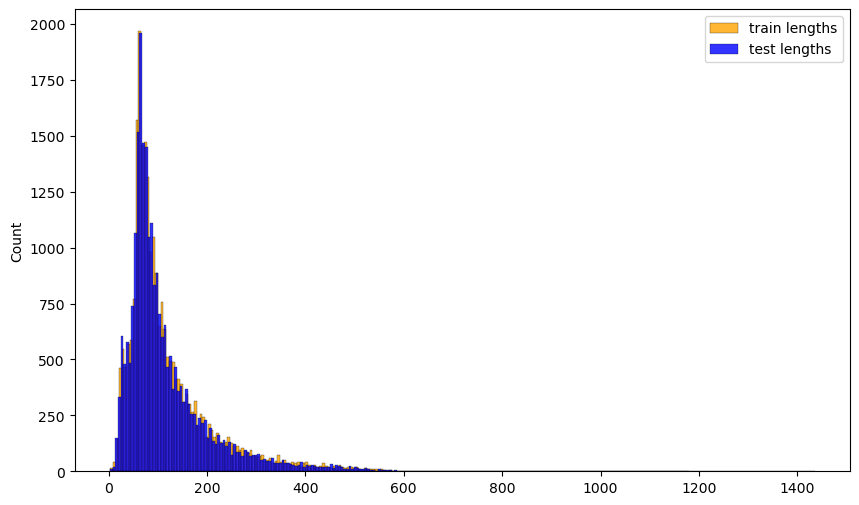

In [15]:
print("--- Train ---")
print("Nombre de mots moyens par phrase : ", int(mean_words_train))
print("Nombre de mots minimum par phrase : ", min_words_train)
print("Nombre de mots maximum par phrase : ", max_words_train)
print("Nombre de mots uniques: ", total_train)

print("--- Test ---")
print("Nombre de mots moyens par phrase : ", int(mean_words_test))
print("Nombre de mots minimum par phrase : ", min_words_test)
print("Nombre de mots maximum par phrase : ", max_words_test)
print("Nombre de mots uniques: ", total_test)

plt.figure(figsize = (10,6))
sns.histplot(x=words_per_sentences_train, color='orange', alpha=.8)
sns.histplot(x=words_per_sentences_test, color='blue', alpha=.8)
plt.legend(['train lengths', 'test lengths'])    

**Observations :**

On remarque dans ce graphe que l'on a des différences importantes de longueur de phrases. La plupart des phrases ont une longueur entre 50 et 250 mots et en moyenne 120 mots (pour le train et le test). 
On va donc maintenant appliquer une troncature sur les phrases ayant plus de 300 mots.

In [16]:
def tronq_sentences(dataset, words_per_sentences, tronc):
    text = []
    
    for i, file in enumerate(dataset):
        words = words_per_sentences[i]
        
        if words > tronc:
            file = file[:tronc]
        text.append(file)
        
    return text

In [17]:
text_train = tronq_sentences(clean_train,words_per_sentences_train,tronc=300)
text_test = tronq_sentences(clean_test,words_per_sentences_test, tronc=300)

## 3. Prétraitement des données sous forme de token

Une fois que l'on a fixé la taille des phrases, nous pouvons maintenant procéder à la tokenisation.

Nous avons choisi d'utiliser le tokenizer Bert car il a été entrainé sur des mots anglais et produit des résultats qui sont bons. 

Dans la fonction ci-dessous nous appliquons encore une méthode de troncature et nous rajoutons du padding. En effet, le modèle Bert n'utilise pas forcément un token pour un mot donc on peut se retrouver à avoir une taille supérieure après la tokenisation que notre nombre de mots.

In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_and_pad(dataset, max_length=256):
    tokenized_sentences = []

    for sentence in dataset:
        encoded = tokenizer.encode(
            sentence)

        if len(encoded) > max_length:
            encoded = encoded[:max_length]

        if len(encoded) < max_length:
            encoded += [0] * (max_length - len(encoded))

        tokenized_sentences.append(encoded)

    return torch.tensor(tokenized_sentences)

In [19]:
train_encoded = tokenize_and_pad(text_train)
test_encoded = tokenize_and_pad(text_test)

## 4. Création des datasets

Maintenant que nous avons entièrement traité les textes, nous pouvons créer nos datasets.

Tout d'abord on s'assure de la taille de nos données et de leur format. On vérifie qu'ils sont bien sous forme de tenseurs.
De plus, nous allons rajouter les labels correspondant pour chaque phrase : 1 si positif et 0 si négatif.

In [20]:
X_train = train_encoded
X_test = test_encoded

In [21]:
# Définition de notre vocab_size.
vocab_size = len(tokenizer.vocab) 

In [22]:
print(X_train[0].shape)

torch.Size([256])


In [23]:
# On vérifie qu'on a bien que des tenseurs
print(type(X_train))
print(type(X_train[0]))
print(type(X_train[0][0]))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


### 4.1 Création des labels

In [24]:
review_to_category = {
    'neg': 0,
    'pos': 1,
}

In [25]:
def labels (paths) : 
    categories = []
    for filename in paths:
        review = filename.split('\\')[0].split('/')[2]
        category = review_to_category.get(review)
        categories.append(category)
    return categories

In [26]:
Y_train = labels(filepaths_train)
Y_test = labels(filepaths_test)

In [27]:
print(Y_train[0])

1


### 4.2 Création du dataset et du dataloader

Pour entrainer nos modèles nous avons choisi de créer un jeu de données de validation qui représente 20% du jeu de données d'entrainement inital.
Cela nous permet de contrôler le surapprentissage.

In [145]:
Y_train = torch.Tensor(Y_train)
print(X_train.shape,Y_train.shape)

ds_train = TensorDataset(X_train,Y_train)
dataloader_train = DataLoader(ds_train,batch_size=256,shuffle=True, drop_last = True)

torch.Size([25000, 256]) torch.Size([25000])


In [146]:
train_size = int(0.8 * len(ds_train)) 
val_size = len(ds_train) - train_size 
ds_train, ds_val = random_split(ds_train, [train_size, val_size])

dataloader_train = DataLoader(ds_train, batch_size=256, shuffle=True, drop_last = True)
dataloader_val = DataLoader(ds_val, batch_size=256, shuffle=True, drop_last = True)

print(f"Taille du jeu d'entraînement : {len(ds_train)}")
print(f"Taille du jeu de validation : {len(ds_val)}")

Taille du jeu d'entraînement : 20000
Taille du jeu de validation : 5000


In [147]:
Y_test = torch.Tensor(Y_test)
print(X_test.shape,Y_test.shape)

ds_test = TensorDataset(X_test,Y_test)
dataloader_test = DataLoader(ds_test,batch_size=256,shuffle=True, drop_last = True)

print(f"Taille du jeu de test : {len(ds_test)}")

torch.Size([25000, 256]) torch.Size([25000])
Taille du jeu de test : 25000


## 5. Entrainement des modèles

Dans cette partie nous allons définir nos différentes architectures et choisir les bons paramètres pour avoir une loss qui diminue et qui converge mais aussi une accuracy qui augmente. 

Nous avons fait le choix d'utiliser pour chacun une couche d'embedding plutôt que de transformer au préalable nos phrases en vecteurs one-hot. Ce choix a été fait suite à de multiples problèmes concernant la taille de nos données et l'espace mémoire diponible. En utilisant une couche d'embedding, cela nous permet de prendre en compte l'ensemble des phrases présentes dans les datasets.

In [128]:
# Définition de la fonction d'entrainement
def train_all(dataloader_train, dataloader_val, model, criterion, optimizer, hidden_size, vocab_size, n_epochs=50):
    losses_train = []
    accuracies_train = []

    losses_val = []
    accuracies_val = []

    start_time = time.time()
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()  # Réinitialiser les stats de mémoire GPU
    
    for epoch in range(n_epochs):
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0
        
        for features, labels in dataloader_train:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features) 
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss_train += loss.item()
            predicted = (outputs > 0.5).int()  
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_loss = running_loss_train / len(dataloader_train)
        losses_train.append(avg_loss)
        accuracy = 100 * correct_train / total_train
        accuracies_train.append(accuracy)

        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for features, labels in dataloader_val:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()
                
                predicted = (outputs.data>0.5).int()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            avg_loss = running_loss_val/ len(dataloader_val)
            losses_val.append(avg_loss)
            accuracy = 100 * correct_val / total_val
            accuracies_val.append(accuracy)
        
        # Affichage toutes les 10 époques
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    total_time = time.time() - start_time
    
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024 * 1024)  # En Mo
    else:
        peak_memory = 0

    print(f"Temps total d'entraînement : {total_time:.2f} secondes")
    print(f"Mémoire GPU maximale utilisée : {peak_memory:.2f} Mo")
    
    return losses_train, accuracies_train, losses_val, accuracies_val, n_epochs, total_time, peak_memory

- vocab_size : La taille du vocabulaire correspond au nombre de mots dans notre dictionnaire. Celui-ci est identique qu'importent les avis et qu'importe le modèle que l'on entraîne. En effet, le dictionnaire est construit sur l'ensemble des avis de la base de données.

- hidden_dim : Ce paramètre permet de jouer sur la dimension de l'espace caché. En effet, plus cette dimension est grande, plus les features sont détaillées. Si cette dimension est trop petite, le modèle peut ne pas capturer des relations importantes dans les données. Si elle est trop grande, le modèle risque de surapprendre ou de devenir trop coûteux en termes de calcul. 

- n_layers : Le nombre de couches dans le RNN. Ajouter plus de couches permet au modèle de capturer des relations plus complexes dans les données, mais cela peut aussi rendre l'entraînement plus difficile ou entraîner un surapprentissage. 

- output_dim : Dans le cas d'une classification binaire, il suffit de rendre un output de dimension 1 car on prédit la probabilité d'être positif. Dans le cas où la proba est supérieure à 0.5, on prédit 1 et dans le cas contraire 0.

Dans ces différents réseaux nous avons, en plus des couches convolutionnelles, implémenté une couche de dropout pour prévenir le phénomène de surapprentissage. La couche fc (Fully Connected) transforme la shape des données pour qu'elle soit compatible avec l'étape de classification. La fonction d'activation séléctionnée est la sigmoid car on fait de la classification binaire. 

### 5.1 RNN

Pour cette première architecture de réseau récurrent. Nous allons simplement coder un RNN régit par les équations suivantes : 
\begin{align*}
a_t &= \tanh(W_{aa}a_{t-1} + W_{ax}x_t + b_a)\\
\hat{y}_t &= W_{ya}a_t + b_y\\
\hat{o}_t &= \text{sigmoid}(\hat{y}_t)
\end{align*}

Pour l'architecture de ce modèle nous avons 3 couches cachées. En effet, lors des entrainements nous avons pu remarquer que plus on avait de couches plus on était précis. Cependant, au-delà de 3 couches les résultats ne s'améliorent pas particulièrement. Nous avons donc décidé de ne pas trop complexifier le modèle pour une compilation plus rapide et éviter le surpparentissage.

In [152]:
class TextRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim, output_dim = 1, n_layers = 3, dropout=0.4):
        super(TextRNN, self).__init__()

        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        
        embedded = self.embedding(text)
        rnn_out, hidden = self.rnn(embedded)

        last_hidden = hidden[-1]
        
        out = self.dropout(last_hidden)
        out = self.fc(out)
        out = self.sig(out)

        return out.squeeze()

In [153]:
# Hyperparamètres
hidden_size = 50
embedding_dim = 100
lr = 1e-3

rnn = TextRNN(vocab_size,hidden_size,embedding_dim ).to(device)
optimizer = Adam(rnn.parameters(), lr=lr)
criterion = nn.BCELoss()

In [154]:
rnn_loss_train, rnn_acc_train, rnn_loss_val, rnn_acc_val, n_epochs, time_rnn, memory_rnn = train_all(dataloader_train, dataloader_val, rnn, criterion, optimizer, hidden_size,vocab_size,n_epochs=20)

Epoch [1/20], Loss: 0.6945, Accuracy: 48.97%
Epoch [11/20], Loss: 0.7060, Accuracy: 48.81%
Temps total d'entraînement : 18.88 secondes
Mémoire GPU maximale utilisée : 797.60 Mo


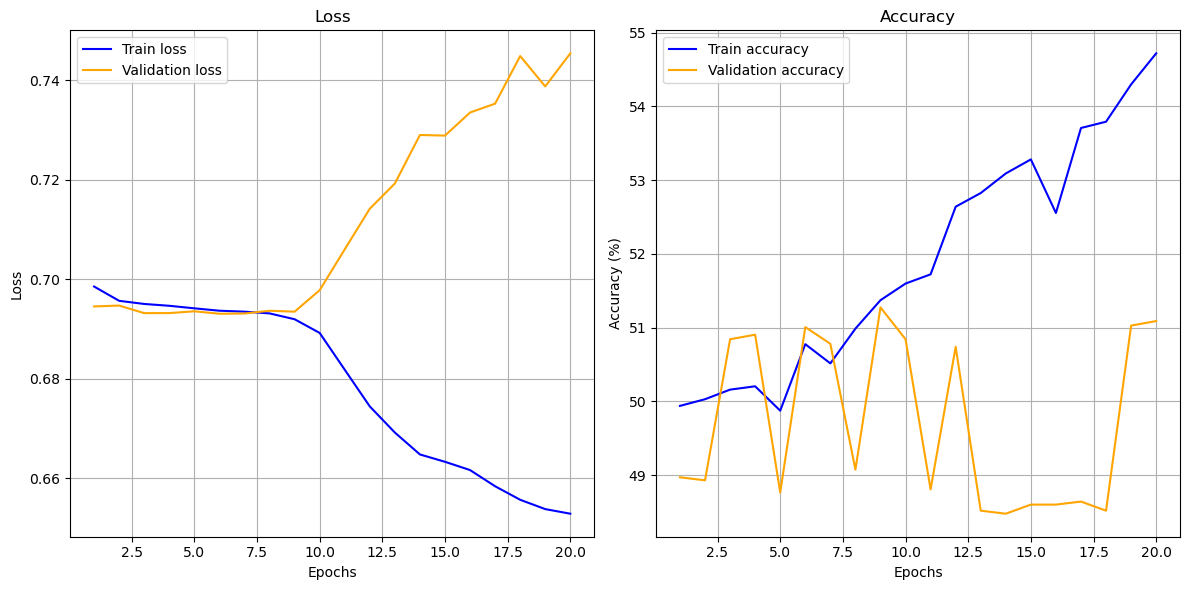

In [155]:
plt.figure(figsize=(12, 6))
    
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), rnn_loss_train, label='Train loss', color='blue')
plt.plot(range(1, n_epochs + 1), rnn_loss_val, label='Validation loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), rnn_acc_train, label='Train accuracy', color='blue')
plt.plot(range(1, n_epochs + 1), rnn_acc_val, label='Validation accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

**Observations :**

On observe que notre modèle surapprend énormément. en effet au bout de 10 epochs, la loss sur le jeu de validation augmente. 
De plus, les performances sont médiocre. La précision oscille autour de 50% pour la validation. Or on a que 2 classes donc cela revient à classifier de manière aléatoire.

### 5.2 LSTM

L'avantage d'un LSTM comparé à un RNN est sa mémoire longue qui résout le problème du vanishing gradient. Cela s'adapte aussi aux données de tailles variables. Sauf que dans notre cas, nous avons choisi de mettre les données toutes de la même taille. De plus, en prétraitant nos données nous avons simplifié la structure des phrases et donc la tokenization. 

C'est pourquoi dans notre étude, un LSTM ne va pas donné de résultats significativement meilleurs que le RNN.

Lors des entrainement du modèle ci-dessous, on a pu observer que l'on fait beaucoup de surapprentissage. C'est pourquoi nous avons un dropout à 0.8. De plus, nous n'avons mis que 2 couches cachées car c'est un algorithme qui est déjà long et lourd à compiler.

In [156]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim,  output_dim = 1, n_layers = 2, dropout=0.8):
        super(TextLSTM, self).__init__()

        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, text):

        embedded = self.embedding(text)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        last_hidden = hidden[-1]
        
        out = self.dropout(last_hidden)
        out = self.fc(out)
        out = self.sig(out)

        return out.squeeze()

In [391]:
# Hyperparamètres
hidden_size = 50
embedding_dim = 100
lr = 1e-3

lstm = TextLSTM(vocab_size,hidden_size, embedding_dim).to(device)
optimizer = Adam(lstm.parameters(), lr=lr)
criterion = nn.BCELoss()

In [392]:
lstm_loss_train, lstm_acc_train, lstm_loss_val, lstm_acc_val, n_epochs, time_lstm, memory_lstm = train_all(dataloader_train, dataloader_val, lstm, criterion, optimizer, hidden_size,vocab_size,n_epochs=25)

Epoch [1/25], Loss: 0.6929, Accuracy: 51.23%
Epoch [11/25], Loss: 0.6999, Accuracy: 50.16%
Epoch [21/25], Loss: 0.5501, Accuracy: 78.62%
Temps total d'entraînement : 31.69 secondes
Mémoire GPU maximale utilisée : 942.09 Mo


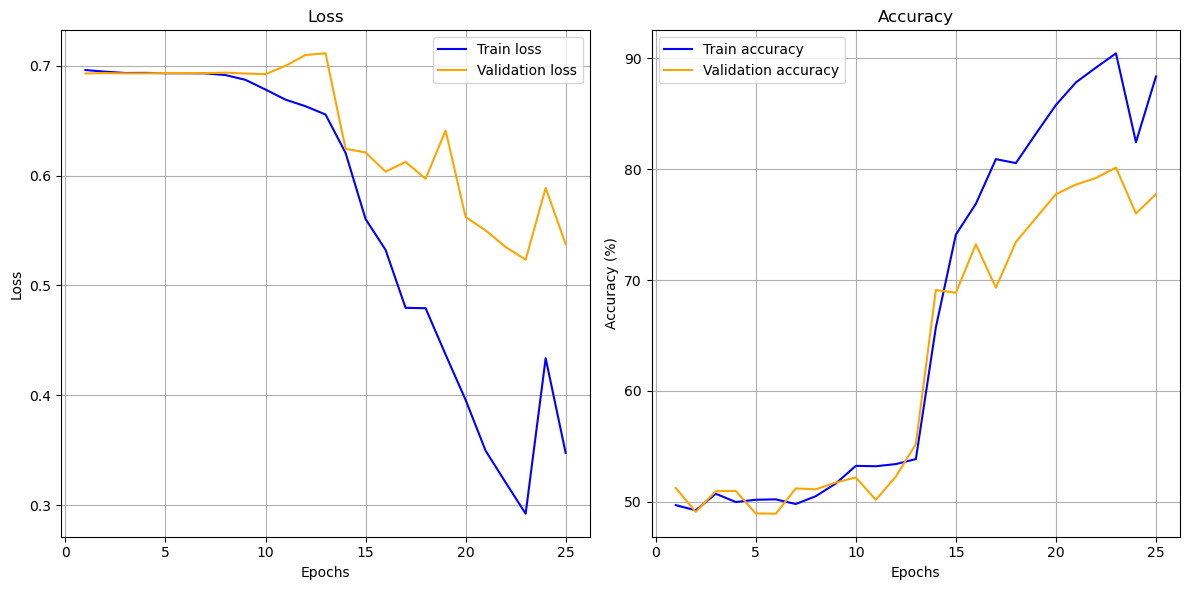

In [393]:
plt.figure(figsize=(12, 6))
    
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), lstm_loss_train, label='Train loss', color='blue')
plt.plot(range(1, n_epochs + 1), lstm_loss_val, label='Validation loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), lstm_acc_train, label='Train accuracy', color='blue')
plt.plot(range(1, n_epochs + 1), lstm_acc_val, label='Validation accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

**Observations :**

Les performances de ce modèles sont bien meilleures avec une préicison de 80% pour la validation et de 90% pour le jeu de données d'entrainement.

Toutefois, le phénomène de surapprentissage est encore présent malgré un dropout à 0.8.

Nous nous sommes arrêtés à 25 epochs pour éviter un trop gros décrochage de la validation.

### 5.3 GRU

Ce modèle est une simplification du LSTM car au lieu de 3 portes il se contente de 2. C'est pourquoi il y a moins de paramètres à estimer et qu'il est plus rapide dans son entrainement. 
Les résultats avec le LSTM sont comparables.

In [160]:
class TextGRU(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim = 100, output_dim = 1, n_layers = 2, dropout=0.8):
        super(TextGRU, self).__init__()

        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, text):

        embedded = self.embedding(text)
        gru_out, hidden = self.gru(embedded)

        last_hidden = hidden[-1]
        
        out = self.dropout(last_hidden)
        out = self.fc(out)
        out = self.sig(out)

        return out.squeeze()

In [161]:
# Hyperparamètres
hidden_size = 50
embedding_dim = 100
lr = 5e-4

gru = TextGRU(vocab_size,hidden_size,embedding_dim).to(device)
optimizer = Adam(gru.parameters(), lr=lr)
criterion = nn.BCELoss()

In [162]:
gru_loss_train, gru_acc_train, gru_loss_val, gru_acc_val, n_epochs, time_gru, memory_gru = train_all(dataloader_train, dataloader_val, gru, criterion, optimizer, hidden_size,vocab_size,n_epochs=35)

Epoch [1/35], Loss: 0.6944, Accuracy: 49.57%
Epoch [11/35], Loss: 0.6934, Accuracy: 49.10%
Epoch [21/35], Loss: 0.6933, Accuracy: 49.18%
Epoch [31/35], Loss: 0.4585, Accuracy: 82.36%
Temps total d'entraînement : 45.20 secondes
Mémoire GPU maximale utilisée : 987.76 Mo


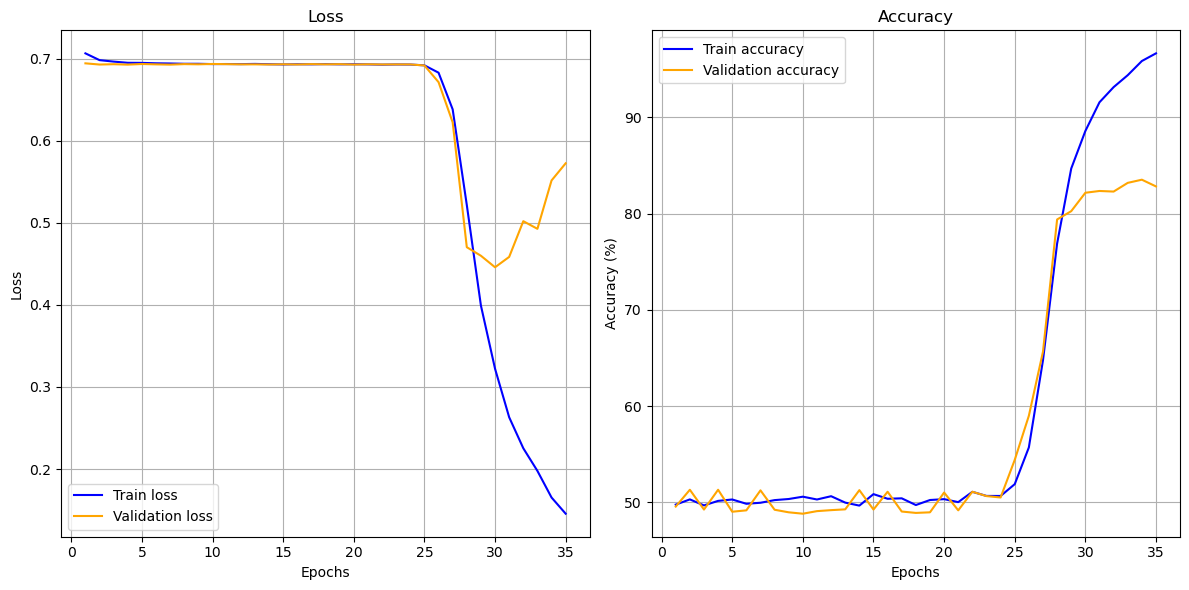

In [163]:
plt.figure(figsize=(12, 6))
    
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), gru_loss_train, label='Train loss', color='blue')
plt.plot(range(1, n_epochs + 1), gru_loss_val, label='Validation loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), gru_acc_train, label='Train accuracy', color='blue')
plt.plot(range(1, n_epochs + 1), gru_acc_val, label='Validation accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

**Observations :**

On observe pour ce modèle de meilleures performances avec une précision de 85% pour la validation et de 97% pour l'entrainement. On observe aussi qu'il y a une sorte de bond dans l'apprentissage.
Si l'on regarde la loss ou la précision, on remarque qu'au bout de la 25e epoch, la précision augmente de 30% et la loss diminue de 0.25 environ.

On observe cependant un fort sur apprentissage apres la 30e epochs similaire au RNN. C'est pourquoi nous nous arrêtons à une trentaine d'epochs pour l'entrainement.

### 5.4 MLP

Le MLP est un réseau de neurones "classiques" dans le sens où il comporte une série de couches linéaires. L'intérêt ici vient du format des inputs (phrases embedded). Ce modèle est rapide d'execution et offre de bons résultats.

Nous avons choisi de mettre 3 couches car dans les modèles précédents on avait au maximum 3 couches cachées. On a pas observé de gros surapprentissage donc on a laissé un dropout à 0.5.

In [164]:
class TextMLP(nn.Module):
    def __init__(self, vocab_size, hidden_dim, embedding_dim, output_dim=1, dropout=0.5):
        super(TextMLP, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, output_dim)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):

        embedded = self.embedding(text)
        pooled = embedded.mean(dim=1)
        mlp_out = self.mlp(pooled)  
        
        out = self.sigmoid(mlp_out) 
        
        return out.squeeze()

In [165]:
# Hyperparamètres
hidden_size = 50
embedding_dim = 100
lr = 1e-4

mlp = TextMLP(vocab_size,hidden_size,embedding_dim).to(device)
optimizer = Adam(mlp.parameters(), lr=lr)
criterion = nn.BCELoss()

In [166]:
mlp_loss_train, mlp_acc_train, mlp_loss_val, mlp_acc_val, n_epochs, time_mlp, memory_mlp = train_all(dataloader_train, dataloader_val, mlp, criterion, optimizer, hidden_size,vocab_size,n_epochs=50)

Epoch [1/50], Loss: 0.6923, Accuracy: 53.39%
Epoch [11/50], Loss: 0.6856, Accuracy: 67.39%
Epoch [21/50], Loss: 0.5357, Accuracy: 76.77%
Epoch [31/50], Loss: 0.4202, Accuracy: 81.50%
Epoch [41/50], Loss: 0.3888, Accuracy: 83.59%
Temps total d'entraînement : 25.40 secondes
Mémoire GPU maximale utilisée : 471.62 Mo


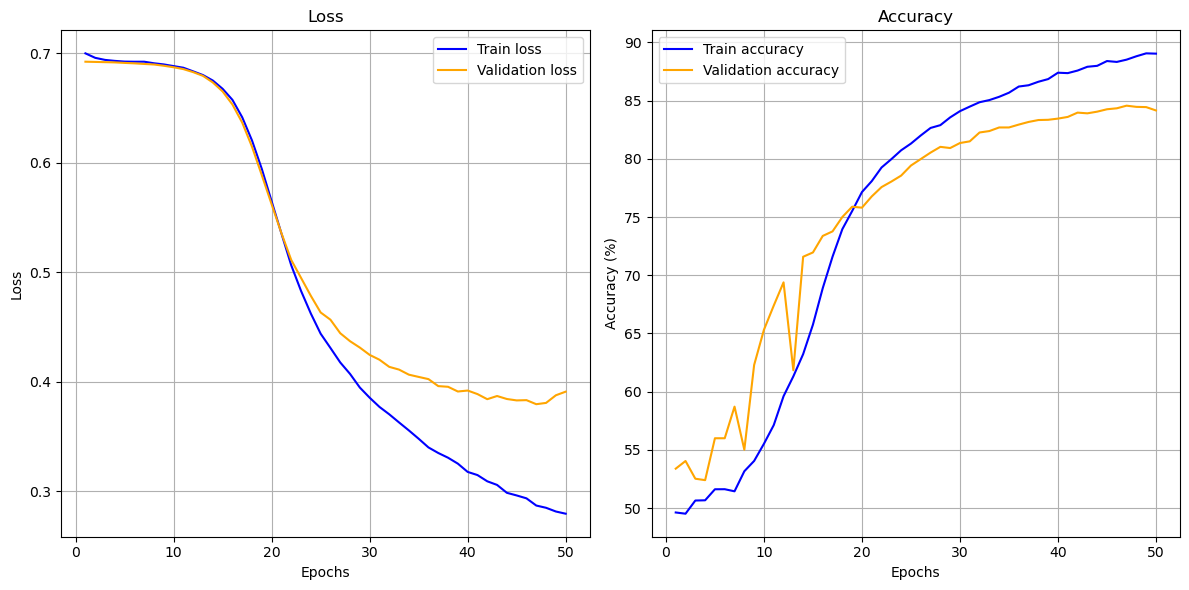

In [167]:
plt.figure(figsize=(12, 6))
    
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), mlp_loss_train, label='Train loss', color='blue')
plt.plot(range(1, n_epochs + 1), mlp_loss_val, label='Validation loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), mlp_acc_train, label='Train accuracy', color='blue')
plt.plot(range(1, n_epochs + 1), mlp_acc_val, label='Validation accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

**Observations :**

Ce modèle présente les meilleures résultats obtenus depuis le début. Il est plus simple et assez rapide. 

On obtient une précision de 85% (respectivement 90%) pour la validation (respectivement l'entrainement). On a une loss qui est plus basse que pour les autres modèles et on remarque aussi que le phénomène de surapprentissage est moins présent.

### 5.5 CNN

Nous allons ici implémenter notre propre CNN en combinant des couches de convolutions (1D car c'est du texte). Comme les réseaux précédents offraient de bons résultats avec 2/3 couches, nous proposons donc un CNN avec 2 couches de convolutions pour avoir un même référentiel pour comparer les résultats.  

Pour l'entrainement de ce modèle, nous avons redéfini une nouvelle fonction d'entrainement car le modèle retourne des données dans un format différent que les autres.

In [182]:
# Définition de la fonction d'entrainement
def train_cnn(dataloader_train, dataloader_val, model, criterion, optimizer, hidden_size, vocab_size, n_epochs=50):
    losses_train = []
    accuracies_train = []

    losses_val = []
    accuracies_val = []

    # Enregistrer le temps de début
    start_time = time.time()

    # Enregistrer la mémoire initiale sur le GPU
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()  # Réinitialiser les stats de mémoire GPU
    
    for epoch in range(n_epochs):
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0
        
        for features, labels in dataloader_train:
            features = features.to(device).float()
            labels = labels.to(device)
            outputs = model(features) 
            outputs = outputs[:,0]
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()
            predicted = (outputs > 0.5).int()  
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_loss = running_loss_train / len(dataloader_train)
        losses_train.append(avg_loss)
        accuracy = 100 * correct_train / total_train
        accuracies_train.append(accuracy)

        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for features, labels in dataloader_val:
                features = features.to(device).float()
                labels = labels.to(device)
                outputs = model(features)
                outputs = outputs[:,0]
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()
                
                predicted = (outputs.data>0.5).int()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
            avg_loss = running_loss_val/ len(dataloader_val)
            losses_val.append(avg_loss)
            accuracy = 100 * correct_val / total_val
            accuracies_val.append(accuracy)
        
        # Affichage toutes les 10 époques
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Temps total d'entraînement
    total_time = time.time() - start_time
    
    # Mémoire utilisée sur le GPU
    if torch.cuda.is_available():
        peak_memory = torch.cuda.max_memory_allocated(device) / (1024 * 1024)  # En Mo
    else:
        peak_memory = 0

    print(f"Temps total d'entraînement : {total_time:.2f} secondes")
    print(f"Mémoire GPU maximale utilisée : {peak_memory:.2f} Mo")
    
    return losses_train, accuracies_train, losses_val, accuracies_val, n_epochs, total_time, peak_memory


In [183]:
cnn = nn.Sequential(
    nn.Conv1d(256, 128, 3, padding='same'),
    nn.ReLU(),
    nn.Dropout(0.5),  
    nn.MaxPool1d(5),
    
    nn.Conv1d(128, 256, 3, padding='same'),
    nn.ReLU(),
    nn.Dropout(0.5),  
    nn.MaxPool1d(5),
    
    nn.Flatten(),
    nn.Linear(10, 250),
    nn.ReLU(),
    nn.Dropout(0.5),  
    
    nn.Linear(250, 1),
    nn.Sigmoid()
)

cnn.to(device)

Sequential(
  (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=same)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=10, out_features=250, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=250, out_features=1, bias=True)
  (13): Sigmoid()
)

In [194]:
lr = 1e-2
optimizer = Adam(cnn.parameters(), lr=lr)
criterion = nn.BCELoss()

In [195]:
cnn_loss_train, cnn_acc_train, cnn_loss_val, cnn_acc_val, n_epochs, time_cnn, memory_cnn = train_cnn(dataloader_train, dataloader_val, cnn, criterion, optimizer, hidden_size,vocab_size,n_epochs=30)

Epoch [1/30], Loss: 31.2644, Accuracy: 49.61%
Epoch [11/30], Loss: 29.5425, Accuracy: 48.79%
Epoch [21/30], Loss: 29.8379, Accuracy: 48.97%
Temps total d'entraînement : 16.15 secondes
Mémoire GPU maximale utilisée : 412.33 Mo


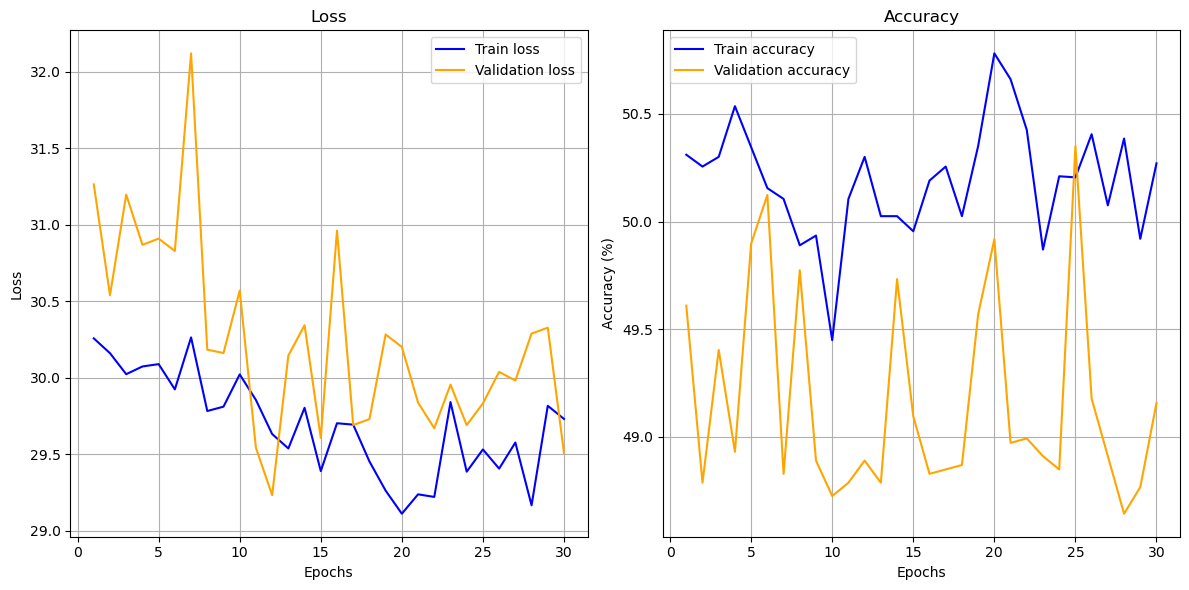

In [196]:
plt.figure(figsize=(12, 6))
    
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), cnn_loss_train, label='Train loss', color='blue')
plt.plot(range(1, n_epochs + 1), cnn_loss_val, label='Validation loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), cnn_acc_train, label='Train accuracy', color='blue')
plt.plot(range(1, n_epochs + 1), cnn_acc_val, label='Validation accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

**Observations :**

Ce modèle produit de mauvais résultats. On observe une loss 100 fois plus grande que pour l'ensemble des précédents modèles. 

Si l'on s'interesse à la précision, on observe qu'elle oscille autour de 50% ce qui revient à faire une classification aléatoire de nos inputs.

## 6. Comparaison des modèles

Dans cette partie nous allons comparer l'efficacité des modèles. Pour cela nous allons utiliser 3 unité de mesure : 
- le temps d'entrainement du modèle
- l'allocation mémoire du modèle
- la précision sur le jeu de données test du modèle.

### 6.1 Analyse des temps d'éxecution

In [274]:
print("Temps d'exécution du CNN : ", time_cnn, "s")
print("Temps d'exécution du RNN : ", time_rnn, "s")
print("Temps d'exécution du MLP : ", time_mlp, "s")
print("Temps d'exécution du GRU : ", time_gru, "s")
print("Temps d'exécution du LSTM : ", time_lstm, "s")

Temps d'exécution du CNN :  16.152852535247803 s
Temps d'exécution du RNN :  18.882577657699585 s
Temps d'exécution du MLP :  25.398146390914917 s
Temps d'exécution du GRU :  45.20178508758545 s
Temps d'exécution du LSTM :  87.7086534500122 s


**Observations :**

On remarque que le CNN et le RNN sont rapides à entrainer. Cependant, on peut noter que le LSTM est le modèle qui est le plus long à entrainer ce qui réprésente presque 7 fois plus que les premiers modèles.

### 6.2 Analyse des tailles mémoires

In [278]:
print("Allocation mémoire du CNN : ", memory_cnn, "octets")
print("Allocation mémoire du MLP : ", memory_mlp, "octets")
print("Allocation mémoire du RNN : ", memory_rnn, "octets")
print("Allocation mémoire du GRU : ", memory_gru, "octets")
print("Allocation mémoire du LSTM : ", memory_lstm, "octets")

Allocation mémoire du CNN :  412.33349609375 octets
Allocation mémoire du MLP :  471.61962890625 octets
Allocation mémoire du RNN :  797.599609375 octets
Allocation mémoire du GRU :  987.75927734375 octets
Allocation mémoire du LSTM :  1504.3115234375 octets


**Observations :**

On observe d'après les résultats ci-dessus que le modèle nécéssitant le plus de mémoire est le LSTM. 

### 6.3 Précisions obtenues pour le jeu de données test

In [374]:
# Définition de la fonction test
def test_all(dataloader, model) :
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in dataloader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            predicted = (outputs.data>0.5).int()
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
    return test_accuracy

# Définition de la fonction test pour CNN
def test_cnn(dataloader, model) :
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in dataloader:
            features = features.to(device).float()
            labels = labels.to(device)
            
            outputs = model(features)
            outputs = outputs[:,0]
            predicted = (outputs.data>0.5).int()
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
    return test_accuracy

In [375]:
# Fonction produit en croix pour l'accuracy
def pec(acc) :
    return acc*100/len(ds_test)
    
# Calcul des accuracy pour tous les modèles
def predict_test(dataloader,models) :
    acc_mod = []
    
    for model in models[:-1] :
        acc_mod.append(test_all(dataloader,model))
    acc_mod.append(test_cnn(dataloader,models[-1]))
          
    return acc_mod

In [394]:
models = [rnn, lstm, gru, mlp, cnn]

acc_test = predict_test(dataloader_test,models)

In [395]:
print("Précision du RNN : ", acc_test[0], "%")
print("Précision du CNN : ", acc_test[4], "%")
print("Précision du LSTM : ", acc_test[1], "%")
print("Précision du GRU : ", acc_test[2], "%")
print("Précision du MLP : ", acc_test[3], "%")

Précision du RNN :  49.92751288659794 %
Précision du CNN :  49.99194587628866 %
Précision du LSTM :  75.40270618556701 %
Précision du GRU :  81.76949097938144 %
Précision du MLP :  83.30782860824742 %


**Observations :**

Pour conclure, le modèle le plus performant est le MLP. Ce modèle est aussi rapide à entrainer et n'est pas trop coûteux en mémoire. 
On peut remarquer que le modèle GRU offre une précision similaire avec 81%. Ce modèle est néanmoins un peu moins rapide et plus lourd en mémoire que le MLP.

On retrouve bien le fait que le RNN ne soit pas un bon modèle pour l'analyse de sentiment, il reste cependant rapide à entrainer.
Le LSTM quant à lui va nous permettre d'avoir une meilleure précision que le RNN mais est beaucoup plus lent et gros en mémoire à cause de ses 3 portes.

Le GRU est bien moins gros en mémoire car il n'a que 2 portes, il est plus rapide à entrainer aussi et nous permet d'améliorer notre précision.

Enfin, le CNN ne permet pas d'avoir une bonne précision. Ce modèle est très simple et il serait peut-être intéressant de le complexifier pour voir s'il y a une amélioration. Cependnat, il ne nous permettra pas d'avoir de super bons résultats.

## 7. Vote majoritaire

Dans cette partie on va chercher à créer un classifieur qui va associer à une phrase la majorité des classes prédites par les 5 modèles entrainées précédemment.

On cherche à regarder quel modèle influe le plus dans la décision du vote majoritaire.

In [378]:
# Vote majoritaire pour un seul label
def majority_vote(predicted) : 
    count_ones = predicted.count(1)
    count_zeros = predicted.count(0)
    if count_ones > count_zeros:
        return 1
    else:
        return 0

In [379]:
# Vote majoritaire pour toutes les prédictions
# Accuracy du classifier de vote majoritaire
# Importance des modèles dans le vote majoritaire
def predict_all(dataloader,models) :
    running_loss = 0.0
    correct = 0
    total = 0

    acc_r = 0
    acc_l = 0
    acc_g = 0
    acc_m = 0
    acc_c = 0
    
    with torch.no_grad():
        for features, labels in dataloader:
            y_pred = []

            # RNN, LSTM, GRU, MLP
            for model in models[:-1] :
                model.eval()
                features = features.to(device)
                labels = labels.to(device)
                
                outputs = model(features)
                predicted = (outputs.data>0.5).int()
                
                y_pred.append(predicted)

            # CNN
            model = models[-1]
            model.eval()
            features = features.to(device).float()
            labels = labels.to(device)
            
            outputs = model(features)
            outputs = outputs[:,0]
            predicted = (outputs.data>0.5).int()
            y_pred.append(predicted)

            for i in range(len(labels)) :
                # Prédictions pour la phrase i
                y_pred_item = [y_pred[0][i].item(), y_pred[1][i].item(), y_pred[2][i].item(), y_pred[3][i].item(), y_pred[4][i].item()]
                # Vote majoritaire pour la phrase i
                y_mv = majority_vote(y_pred_item)
                # Accuracy du classifier majority vote
                correct += (y_mv == labels[i])
                # Importance de chaque modèle dans le classifier
                acc_r += (y_pred_item[0]== y_mv)
                acc_l += (y_pred_item[1] == y_mv)
                acc_g += (y_pred_item[2] == y_mv)
                acc_m += (y_pred_item[3] == y_mv)
                acc_c += (y_pred_item[4] == y_mv)
            
        acc = pec(correct)
        acc_mod = [pec(acc_r),pec(acc_l),pec(acc_g),pec(acc_m),pec(acc_c)]
    return acc.item(), acc_mod

In [396]:
acc,acc_mod = predict_all(dataloader_test,models)

In [397]:
print("Précision du classifier par vote majoritaire : ",acc,"%")
print("--- Importance des modèles dans le vote majoritaire ---")
print("RNN :",acc_mod[0],"%")
print("CNN :",acc_mod[4],"%")
print("LSTM :",acc_mod[1],"%")
print("GRU :",acc_mod[2],"%")
print("MLP :",acc_mod[3],"%")

Précision du classifier par vote majoritaire :  83.32799530029297 %
--- Importance des modèles dans le vote majoritaire ---
RNN : 50.72 %
CNN : 50.644 %
LSTM : 83.588 %
GRU : 90.712 %
MLP : 88.828 %


**Observations :**

On remarque que notre classifieur par vote majoritaire a une précision de 84% ce qui est un bon résultat. 

On peut aussi remarquer que le classifieur par vote majoritaire a 90% de ces prédictions qui sont similaires à celles du GRU. On on conclut que le modèle GRU est celui qui est le plus influent dans la classification par vote majoritaire.